### Installing MediaPipe

In [8]:
%%capture
!pip install mediapipe
# !pip install protobuf==3.20.*
# !pip install opencv-python
# !pip install opencv-contrib-python
# !pip install "opencv-python-headless<4.3"

### Import Libraries

In [9]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

### Download The Data

In [10]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

### Preparing the Data

In [11]:
filePath = [Path(f).stem for f in glob.glob('AFLW2000/*.jpg')]
print(filePath)

['image00972', 'image04180', 'image01086', 'image00334', 'image03075', 'image00862', 'image03026', 'image00527', 'image00726', 'image00960', 'image01469', 'image00545', 'image02592', 'image00122', 'image01163', 'image03926', 'image00082', 'image03892', 'image02295', 'image03453', 'image02073', 'image02030', 'image01773', 'image00329', 'image02080', 'image01472', 'image02332', 'image01785', 'image02038', 'image02544', 'image03835', 'image02054', 'image03624', 'image00036', 'image02034', 'image01329', 'image03791', 'image03984', 'image01087', 'image02769', 'image00734', 'image03908', 'image03765', 'image00360', 'image02739', 'image02513', 'image03270', 'image04062', 'image03977', 'image01346', 'image00294', 'image03013', 'image01762', 'image00753', 'image00826', 'image02803', 'image02996', 'image02494', 'image02310', 'image00352', 'image01202', 'image04248', 'image02846', 'image00391', 'image01300', 'image03800', 'image00613', 'image02947', 'image02154', 'image00035', 'image02257', 'imag

### Features Extarctions

In [12]:
def get_face_mesh(img, draw=False, dir_path='AFLW2000/'):
  x_axis = []
  y_axis = []

  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      image = cv2.imread(dir_path+img+'.jpg')

      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y

                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                
                x_axis.append(relative_x)
                y_axis.append(relative_y)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #if draw == True:
              #cv2_imshow(image)
  return x_axis, y_axis

In [13]:
def get_labels(img, dir_path='AFLW2000/'):
  mat_file = sio.loadmat(dir_path+img+'.mat')
  # extracting the labels 3 angels
  pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  return [yaw, pitch, roll, img]

In [14]:
def feature_extraction(dir_path='AFLW2000/'):
  imagePath = [Path(f).stem for f in glob.glob(dir_path+'*.jpg')]
  x_features = []
  y_features = []
  labels = []
  for img in imagePath:
    labels.append(get_labels(img))
    x_axis, y_axis = get_face_mesh(img, dir_path)
    x_features.append(x_axis)
    y_features.append(y_axis)
  print('x_axis: ', len(x_features))
  print('x_axis: ', len(y_features))
  print('labels: ', len(labels))
  x_points_col = ['X{}'.format(i) for i in range(468)]
  y_points_col = ['Y{}'.format(i) for i in range(468)]
  df_x = pd.DataFrame(x_features,columns=x_points_col)
  df_x = df_x.astype(float)
  df_y = pd.DataFrame(y_features,columns=y_points_col)
  df_y = df_y.astype(float)
  labels_names = ['yaw', 'pitch', 'roll', 'image']
  df_labels = pd.DataFrame(labels,columns=labels_names)
  train_df = pd.concat([df_x, df_y, df_labels], axis=1, join='inner')
  train_df = train_df.dropna()
  return train_df

In [15]:
train_df = feature_extraction()
train_df

x_axis:  2000
x_axis:  2000
labels:  2000


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y462,Y463,Y464,Y465,Y466,Y467,yaw,pitch,roll,image
0,223.0,220.0,222.0,213.0,220.0,220.0,220.0,157.0,220.0,219.0,...,278.0,220.0,222.0,223.0,211.0,208.0,0.066288,0.075391,-0.076080,image00972
1,208.0,189.0,207.0,190.0,186.0,188.0,202.0,188.0,203.0,201.0,...,295.0,221.0,226.0,230.0,214.0,205.0,0.752342,-0.514121,-0.341487,image04180
2,231.0,228.0,229.0,217.0,227.0,226.0,222.0,149.0,220.0,219.0,...,292.0,213.0,217.0,221.0,197.0,193.0,-0.027759,-0.347319,-0.091287,image01086
3,203.0,198.0,207.0,205.0,199.0,203.0,219.0,199.0,226.0,227.0,...,276.0,234.0,235.0,236.0,241.0,239.0,0.567679,-0.029032,0.240908,image00334
5,193.0,210.0,209.0,229.0,216.0,226.0,252.0,218.0,269.0,277.0,...,260.0,243.0,240.0,237.0,271.0,272.0,0.223025,0.442086,0.786156,image00862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,195.0,198.0,205.0,210.0,201.0,208.0,231.0,196.0,243.0,247.0,...,267.0,223.0,223.0,222.0,236.0,234.0,0.667445,0.210636,0.484012,image00728
1994,229.0,218.0,224.0,210.0,216.0,215.0,215.0,172.0,213.0,210.0,...,281.0,229.0,231.0,233.0,218.0,214.0,0.249940,-0.119610,-0.192510,image03732
1995,230.0,245.0,234.0,238.0,247.0,246.0,241.0,181.0,242.0,244.0,...,282.0,229.0,232.0,235.0,224.0,220.0,-0.478792,-0.537956,0.254959,image02775
1997,194.0,199.0,202.0,208.0,201.0,207.0,225.0,196.0,235.0,238.0,...,263.0,230.0,230.0,229.0,240.0,238.0,0.604873,0.282187,0.474036,image03890


In [16]:
train_df.isna().sum().sum()

0

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1853 entries, 0 to 1998
Columns: 940 entries, X0 to image
dtypes: float64(939), object(1)
memory usage: 13.3+ MB


### Draw The axis

In [18]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Centring and cropping the data

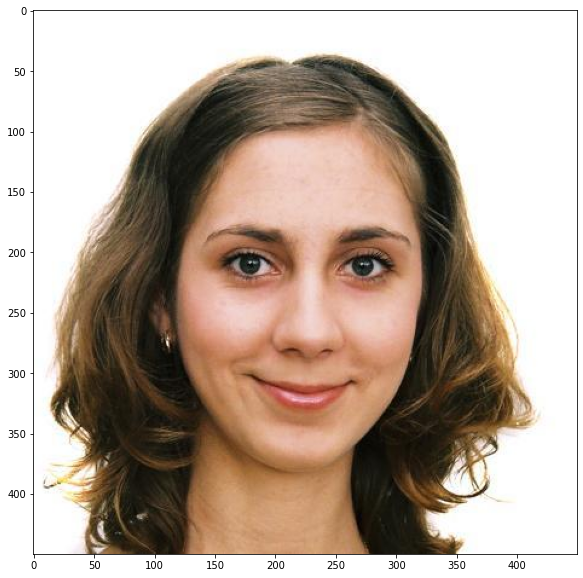

In [ ]:
img1 = 'image00052'
imag1 = cv2.imread('AFLW2000/'+img1+'.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(imag1, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
#for img in filePath:
def crop_image(df, img, dir_path='AFLW2000/'):
  image1 = cv2.imread(dir_path+img+'.jpg')
  df_test = df[df['image'] == img]
  df_test_X = df_test.loc[:, df_test.columns.str.startswith('X')]
  df_test_Y = df_test.loc[:, df_test.columns.str.startswith('Y')]

  min_x = int(df_test_X.min(axis=1).values[0])
  max_x = int(df_test_X.max(axis=1).values[0])
  min_Y = int(df_test_Y.min(axis=1).values[0])
  max_Y = int(df_test_Y.max(axis=1).values[0])

  crop_top = image1[min_Y:max_Y, min_x:max_x, :]
  #plt.figure(figsize=(10,10))
  #plt.imshow(cv2.cvtColor(crop_top, cv2.COLOR_BGR2RGB))
  #cv2.imwrite('/content/AFLW2000/'+img+'.jpg', crop_top)
  #plt.show()
  return crop_top

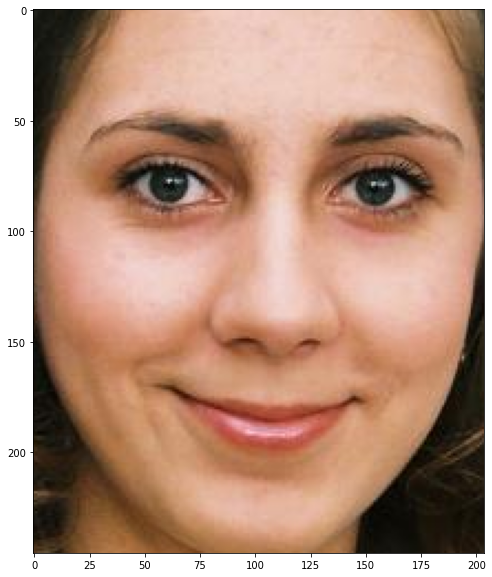

In [ ]:
img = 'image00052'
croped_image = crop_image(train_df, img)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(croped_image, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
%%capture
if not os.path.exists('/content/cropped_images/'):
  os.mkdir('/content/cropped_images/')


In [21]:
for img in train_df['image']:
  croped_image = crop_image(train_df, img)
  if croped_image.size > 0:
    cv2.imwrite('cropped_images/'+img+'.jpg', croped_image)

### Model

In [22]:
cropped_df = feature_extraction('/content/cropped_images/')
cropped_df

x_axis:  1852
x_axis:  1852
labels:  1852


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y462,Y463,Y464,Y465,Y466,Y467,yaw,pitch,roll,image
0,223.0,220.0,222.0,213.0,220.0,220.0,220.0,157.0,220.0,219.0,...,278.0,220.0,222.0,223.0,211.0,208.0,0.066288,0.075391,-0.076080,image00972
1,208.0,189.0,207.0,190.0,186.0,188.0,202.0,188.0,203.0,201.0,...,295.0,221.0,226.0,230.0,214.0,205.0,0.752342,-0.514121,-0.341487,image04180
2,231.0,228.0,229.0,217.0,227.0,226.0,222.0,149.0,220.0,219.0,...,292.0,213.0,217.0,221.0,197.0,193.0,-0.027759,-0.347319,-0.091287,image01086
3,203.0,198.0,207.0,205.0,199.0,203.0,219.0,199.0,226.0,227.0,...,276.0,234.0,235.0,236.0,241.0,239.0,0.567679,-0.029032,0.240908,image00334
4,193.0,210.0,209.0,229.0,216.0,226.0,252.0,218.0,269.0,277.0,...,260.0,243.0,240.0,237.0,271.0,272.0,0.223025,0.442086,0.786156,image00862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,195.0,198.0,205.0,210.0,201.0,208.0,231.0,196.0,243.0,247.0,...,267.0,223.0,223.0,222.0,236.0,234.0,0.667445,0.210636,0.484012,image00728
1848,229.0,218.0,224.0,210.0,216.0,215.0,215.0,172.0,213.0,210.0,...,281.0,229.0,231.0,233.0,218.0,214.0,0.249940,-0.119610,-0.192510,image03732
1849,230.0,245.0,234.0,238.0,247.0,246.0,241.0,181.0,242.0,244.0,...,282.0,229.0,232.0,235.0,224.0,220.0,-0.478792,-0.537956,0.254959,image02775
1850,194.0,199.0,202.0,208.0,201.0,207.0,225.0,196.0,235.0,238.0,...,263.0,230.0,230.0,229.0,240.0,238.0,0.604873,0.282187,0.474036,image03890


In [23]:
cropped_df = pd.read_csv('cropped_data.csv')
cropped_df

,image_name,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,...,Y465,X466,Y466,X467,Y467,X468,Y468,pitch,yaw,roll
0,image00336,117.0,116.0,133.0,99.0,119.0,103.0,128.0,77.0,136.0,...,63.0,124.0,65.0,130.0,65.0,130.0,65.0,-0.280651,-1.213959,0.784340
1,image00065,104.0,177.0,107.0,149.0,106.0,156.0,103.0,114.0,108.0,...,92.0,128.0,93.0,181.0,88.0,186.0,86.0,-0.138030,0.002317,0.090606
2,image03043,112.0,169.0,125.0,144.0,118.0,151.0,124.0,112.0,128.0,...,96.0,143.0,97.0,185.0,99.0,189.0,97.0,-0.236607,-0.200545,0.303587
3,image00100,122.0,177.0,127.0,150.0,123.0,155.0,117.0,116.0,127.0,...,82.0,134.0,85.0,177.0,66.0,181.0,63.0,-0.314558,-0.152918,0.015975
4,image00333,79.0,167.0,82.0,136.0,83.0,147.0,84.0,104.0,84.0,...,89.0,114.0,90.0,168.0,90.0,173.0,89.0,0.109903,0.119938,0.137979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,image01438,61.0,122.0,51.0,112.0,57.0,112.0,47.0,87.0,50.0,...,62.0,72.0,65.0,117.0,56.0,121.0,53.0,-0.421204,0.329491,-0.036512
1755,image01901,67.0,139.0,69.0,104.0,71.0,119.0,71.0,81.0,70.0,...,76.0,103.0,75.0,155.0,79.0,162.0,76.0,0.322875,0.174730,0.176558
1756,image00516,129.0,129.0,136.0,106.0,128.0,112.0,125.0,84.0,137.0,...,64.0,127.0,66.0,151.0,60.0,153.0,56.0,-0.017282,-0.623240,0.098033
1757,image04298,95.0,172.0,91.0,144.0,94.0,151.0,83.0,113.0,90.0,...,85.0,107.0,88.0,158.0,71.0,162.0,69.0,-0.239913,0.083054,-0.083933


In [24]:
cropped_df.rename(columns = {'image_name':'image'}, inplace = True)

In [25]:
cropped_df.isna().sum().sum()

0

In [26]:
features_df = cropped_df.drop(['yaw', 'pitch', 'roll','image'], axis=1)
labels_df = cropped_df.drop(cropped_df.columns.difference(['yaw', 'pitch', 'roll']), axis=1)

In [27]:
features_df.shape

(1759, 936)

In [28]:
labels_df.shape

(1759, 3)

#### Applying PCA

In [29]:
pca = PCA(n_components=50, whiten=True)

In [30]:
features_df = pca.fit_transform(features_df)
features_df.shape

(1759, 50)

In [31]:
normalization = StandardScaler()
features_df = normalization.fit_transform(features_df)
features_df.shape

(1759, 50)

In [32]:
features_train, features_test, labels_train, labels_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)

In [33]:
model = MultiOutputRegressor(LinearSVR(C=0.1, dual=True, epsilon=0.05, loss='epsilon_insensitive', tol=1e-5, max_iter=10000)).fit(features_train, labels_train)

In [34]:
y_pred_train = model.predict(features_train)
y_pred_test = model.predict(features_test)
print("Training r2-scores:", r2_score(labels_train, y_pred_train))
print("Testing r2-scores:", r2_score(labels_test, y_pred_test))
print("Training MSE:", mean_squared_error(labels_train, y_pred_train))
print("Testing MSE:", mean_squared_error(labels_test, y_pred_test))

Training r2-scores: 0.45634786826877805
Testing r2-scores: 0.8306830327240539
Training MSE: 0.15010179241064914
Testing MSE: 0.014896280044371548


### Testing the Model in images from the dataset

In [ ]:
img_names_slice = [cropped_df['image'].values[10]]
print(img_names_slice)

['image00545']


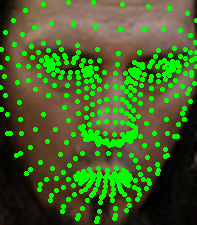

In [ ]:
for img in img_names_slice:
  x, y = get_face_mesh(img, True, '/content/cropped_images/')

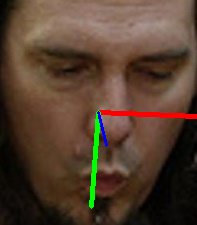

In [ ]:
for img in img_names_slice:
  label = get_labels(img, dir_path='/content/AFLW2000/')
  image = cv2.imread('/content/cropped_images/'+img+'.jpg')
  cv2_imshow(draw_axis(image,label[1],label[0],label[2]))

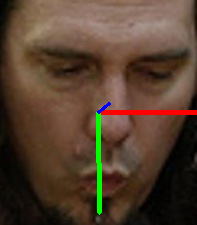

In [ ]:
for img in img_names_slice:
  feature_x, feature_y = get_face_mesh(img, dir_path='/content/cropped_images/')
  x_points_col = ['X{}'.format(i) for i in range(468)]
  y_points_col = ['Y{}'.format(i) for i in range(468)]
  df_x = pd.DataFrame([feature_x],columns=x_points_col)
  df_x = df_x.astype(float)
  df_y = pd.DataFrame([feature_y],columns=y_points_col)
  df_y = df_y.astype(float)
  feature_df = pd.concat([df_x, df_y], axis=1, join='inner')
  feature_df = pca.transform(feature_df)
  feature_df = normalization.transform(feature_df)
  label = model.predict(feature_df)[0]
  image = cv2.imread('/content/cropped_images/'+img+'.jpg')
  cv2_imshow(draw_axis(image,label[1],label[0],label[2]))

### Testing the Model in Live Camera

In [35]:
def get_face_mesh_live(img, draw=False):
    x_axis = []
    y_axis = []
    faceModule = mediapipe.solutions.face_mesh
    
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks != None:
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y

                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])

                    x_axis.append(relative_x)
                    y_axis.append(relative_y)
                    # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                    #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                #if draw == True:
                  #cv2_imshow(image)
    return x_axis, y_axis

In [35]:
liveCam = cv2.VideoCapture(0)
while(True):
    _, frame = liveCam.read()
    df = feature_extraction()
    croped_frame = crop_image(df, frame)
    x_face_points, y_face_points = get_face_mesh_live(croped_frame)
    x_points_col = ['X{}'.format(i) for i in range(468)]
    y_points_col = ['Y{}'.format(i) for i in range(468)]
    df_x = pd.DataFrame([x_face_points],columns=x_points_col)
    df_x = df_x.astype(float)
    df_y = pd.DataFrame([y_face_points],columns=y_points_col)
    df_y = df_y.astype(float)
    feature_df = pd.concat([df_x, df_y], axis=1, join='inner')
    feature_df = pca.transform(feature_df)
    feature_df = normalization.transform(feature_df)
    label = model.predict(feature_df)[0]
    frame = draw_axis(image,label[1],label[0],label[2])
    frame = cv2.resize(frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
    frame = cv2.putText(frame, text, (20, 30), font, fontsize, color=(0, 0, 255))
    frame = cv2.putText(frame, hint1, (20, 50), font, fontsize * 0.8, color=(50, 20, 200))
    frame = cv2.putText(frame, hint2, (20, 65), font, fontsize * 0.8, color=(50, 20, 200))
    frame = cv2.putText(frame, hint3, (20, 80), font, fontsize * 0.8, color=(50, 20, 200))
    cv2.imshow('Head-Pose-Estimation', frame)
    #use Q to close the camera window
    k = cv2.waitKey(1)
    if k == 27:
        break
liveCam.release()
cv2.destroyAllWindows()